In [45]:
import numpy as np
import random

class GridWorld:
    # call to initialize grid world enviroment, default will be a 5x5 grid with a start point at the top left corner and goal at
    # the bottom right corner, no obsticals, if probablity of obsticals is given, these will be placed in enviroment randomly
    def __init__(self, grid_size=(5, 5), start_point=(0, 0), goal_point=None, prob_obstacle=0):
        self.grid_size = grid_size
        self.start_point = start_point
        self.goal_point = goal_point if goal_point is not None else (grid_size[0] - 1, grid_size[1] - 1)
        self.prob_obstacle = prob_obstacle

        self.action_map = ['up', 'down', 'left', 'right']
        self.grid = np.zeros(self.grid_size, dtype=int)
        self._generate_obstacles() 
        self.reset()

        
    # obstacles created based on probability argument passed
    # idealy a small number (> .8) is passed so path to goal is still achivable
    def _generate_obstacles(self):
        self.grid = np.zeros(self.grid_size, dtype=int)
        for r in range(self.grid_size[0]):
            for c in range(self.grid_size[1]):
                if random.random() < self.prob_obstacle and (r, c) != self.start_point and (r, c) != self.goal_point:
                    self.grid[r, c] = 1

    def reset(self):
        self.agent_point = self.start_point

        return self.agent_point

    def step(self, action_idx):
        action = self.action_map[action_idx]
        x, y = self.agent_point
        next_x, next_y = x, y

        if action == 'up' and x > 0:
            next_x -= 1
        elif action == 'down' and x < self.grid_size[0] - 1:
            next_x += 1
        elif action == 'left' and y > 0:
            next_y -= 1
        elif action == 'right' and y < self.grid_size[1] - 1:
            next_y += 1
            
        is_obstacle = self.grid[next_x, next_y] == 1

        if is_obstacle:                              # Penalty applied if agent bumps into obstacle
            next_x, next_y = x, y
            reward = -5
            done = False
        else:
            self.agent_point = (next_x, next_y)     # For non obstacle states, reward ig goal, otherwise penalize 
            done = self.is_at_goal()
            reward = 10 if done else -1

        return self.agent_point, reward, done, {}

    def is_at_goal(self):
        return self.agent_point == self.goal_point
    
    # For debugging 
    def display_env(self):
        world = np.array(self.grid, dtype=object)
        x, y = self.agent_point
        gx, gy = self.goal_point
        world[x, y] = 'A'          # Agent
        world[gx, gy] = 'G'        # Goal
        print(world)

In [46]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

# Network for DQ Agent
class DQNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.fc(x)

In [47]:
class DQNAgent:
    def __init__(self, grid_size, action_size=4, gamma=0.99, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995, lr=1e-3, batch_size=64, memory_size=10000):
        self.grid_size = grid_size                # Size of the grid (grid_size x grid_size)
        self.state_size = 2                       # Size of state size (x, y)
        self.action_size = action_size            # Size of the action space (default 4: up, right, down, left)
        self.gamma = gamma                        # Discount factor
        self.epsilon = epsilon                    # Initial exploration rate
        self.epsilon_min = epsilon_min            # Minimum exploration rate, allows for agent to continue exploring     
        self.epsilon_decay = epsilon_decay        # Decay rate for exploration
        self.batch_size = batch_size

        self.memory = deque(maxlen=memory_size)
        self.model = DQNetwork(self.state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.criterion = nn.MSELoss()

    def update(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def get_action(self, state, training=True):
        # Get the current state, determine if exploration or exploitation 
        if training and np.random.rand() < self.epsilon:
            return np.random.randint(self.action_size)

        # Predict Q values
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            return torch.argmax(self.model(state)).item()

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)

        # From sample mini batch, train
        for state, action, reward, next_state, done in minibatch:
            state_tensor = torch.FloatTensor(state)
            next_state_tensor = torch.FloatTensor(next_state)
            target = reward

            # Calculate target Q value
            if not done:
                target += self.gamma * torch.max(self.model(next_state_tensor)).item()

            predicted = self.model(state_tensor)[action]                   # Predict Q value
            target_tensor = torch.tensor(target, dtype=torch.float)
            loss = self.criterion(predicted, target_tensor)                # compute loss
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

         # Decay exploration rate
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [48]:
import os
import time

def train_dqn(env, agent, episodes=500, max_steps=100, log_interval=100):
    rewards = []
    steps_list = []
    start_time = time.time()
    total_reward_accumulated = 0

    for episode in range(episodes):
        state = np.array(env.reset())
        total_reward = 0

        for step in range(max_steps):
            action = agent.get_action(state)                         # Get action
            next_state, reward, done, _ = env.step(action)           # Take step
            next_state = np.array(next_state)
            agent.update(state, action, reward, next_state, done)    # Update state

            # Update state and total reward
            state = next_state
            total_reward += reward

            if done:
                break

        agent.replay()
        rewards.append(total_reward)
        total_reward_accumulated += total_reward
        steps_list.append(step + 1)

        if episode % log_interval == 0:
            avg_reward = np.mean(rewards[-log_interval:])
            avg_steps = np.mean(steps_list[-log_interval:])
            print(f"Episode {episode}/{episodes} | Avg Reward: {avg_reward:.2f} | Avg Steps: {avg_steps:.2f} | Epsilon: {agent.epsilon:.4f}")


    print(f"\nTraining completed in {time.time() - start_time:.2f} seconds.")
    print(f"\nTotal Reward Accumulated: {total_reward_accumulated}.")
    return rewards

In [55]:
def evaluate_dqn(env, agent, episodes=10, max_steps=100):
    rewards = []
    success_count = 0

    for ep in range(episodes):
        state = np.array(env.reset())
        total_reward = 0
        done = False

        for step in range(max_steps):
            action = agent.get_action(state, training=False)  # Use greedy policy
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            state = np.array(next_state)

            if done:
                if reward == 10:  # Assuming reaching goal gives +10
                    success_count += 1
                break

        rewards.append(total_reward)
        print(f"Episode {ep + 1}/{episodes} | Reward: {total_reward:.2f} | Steps: {step + 1}")

    avg_reward = np.mean(rewards)
    success_rate = success_count / episodes

    print(f"\nEvaluation over {episodes} episodes - Average Reward: {avg_reward:.2f} | Success Rate: {success_rate * 100:.2f}%")

    return rewards

In [49]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
    
def plot_convergence(rewards):
    # Plot Average Reward per Episode
    plt.plot(rewards)
    plt.title('Average Reward per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')


Episode 0/200 | Avg Reward: -134.00 | Avg Steps: 93.00 | Epsilon: 0.9950
Episode 20/200 | Avg Reward: -78.70 | Avg Steps: 66.90 | Epsilon: 0.9001
Episode 40/200 | Avg Reward: -38.40 | Avg Steps: 42.45 | Epsilon: 0.8142
Episode 60/200 | Avg Reward: -33.35 | Avg Steps: 35.75 | Epsilon: 0.7366
Episode 80/200 | Avg Reward: -19.10 | Avg Steps: 27.70 | Epsilon: 0.6663
Episode 100/200 | Avg Reward: -23.00 | Avg Steps: 30.60 | Epsilon: 0.6027
Episode 120/200 | Avg Reward: -9.80 | Avg Steps: 19.20 | Epsilon: 0.5452
Episode 140/200 | Avg Reward: -12.20 | Avg Steps: 22.40 | Epsilon: 0.4932
Episode 160/200 | Avg Reward: -4.65 | Avg Steps: 15.05 | Epsilon: 0.4462
Episode 180/200 | Avg Reward: -3.90 | Avg Steps: 14.30 | Epsilon: 0.4036

Training completed in 31.60 seconds.

Total Reward Accumulated: -4638.


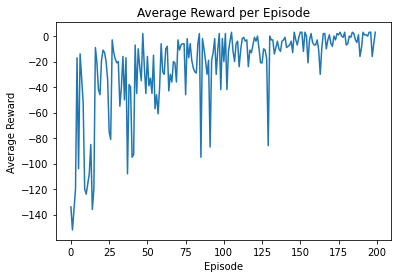

In [54]:
env = GridWorld(grid_size=(5,5), prob_obstacle=0.2)
agent = DQNAgent(grid_size=(5,5))

rewards = train_dqn(env, agent, episodes=200, log_interval=20)
plot_convergence(rewards)

In [56]:
r = evaluate_dqn(env, agent)

Episode 1/10 | Reward: 3.00 | Steps: 8
Episode 2/10 | Reward: 3.00 | Steps: 8
Episode 3/10 | Reward: 3.00 | Steps: 8
Episode 4/10 | Reward: 3.00 | Steps: 8
Episode 5/10 | Reward: 3.00 | Steps: 8
Episode 6/10 | Reward: 3.00 | Steps: 8
Episode 7/10 | Reward: 3.00 | Steps: 8
Episode 8/10 | Reward: 3.00 | Steps: 8
Episode 9/10 | Reward: 3.00 | Steps: 8
Episode 10/10 | Reward: 3.00 | Steps: 8

Evaluation over 10 episodes - Average Reward: 3.00 | Success Rate: 100.00%
